This notebook is part of the [Machine Learning class](https://github.com/erachelson/MLclass) by [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en).

This notebook is joint work by Remy Priem (primary author), Morgane Menz, Mostafa Meliani, Joseph Morlier and Emmanuel Rachelson.

License: CC-BY-SA-NC.

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Gaussian Process Regression (practice session)</div>

# Introduction

A surrogate model is an engineering method used when an outcome of interest cannot be easily directly measured, so a model of the outcome is used instead. Most engineering design problems require experiments and/or simulations to evaluate design objective and constraint functions as function of the design variables. For example, in order to find the optimal airfoil shape for an aircraft wing, an engineer simulates the air flow around the wing for different shape variables (length, curvature, material, ...). For many real world problems, however, a single simulation can take many minutes, hours, or even days to complete. As a result, routine tasks such as design optimization, design space exploration, sensitivity analysis become near impossible since they require a great number of function evaluations.

One way of alleviating this burden is by constructing approximation models, known as surrogate models, response surface models, *metamodels* or emulators, that mimic the behavior of the simulation model as closely as possible while being computationally cheaper to evaluate. Surrogate models are constructed using a data-driven approach. The exact, inner working of the simulation code is not assumed to be known (or even understood), solely the input-output behavior is important.

There exist multiple ways to build an approximation of a function: Artificial Neural Networks, Radial Basis Functions, Support Vector Regressions... 
In all these metamodels (or surrogate models), a fundamental assumption is that the quantity of interest $y(x)$ can be written $(y(x) = \hat{y}(x) + \epsilon)$, where the residuals $\epsilon$ are independently and identically distributed normal random variables, so that fitting the model $\hat{y}(x)$ is performed by minimizing a measure over $\epsilon$.

For a practical example, take a look to this airfoil optimization tool: [http://mdolab.engin.umich.edu/webfoil](http://mdolab.engin.umich.edu/webfoil)

It has been constructed by lot of offline computations and an excellent tool developed jointly by University of Michigan, Nasa, Onera and ISAE-SUPAERO called SMT: [https://github.com/SMTorg/SMT](https://github.com/SMTorg/SMT)

The authors strongly encourage students to have a look to classical textbooks such as [1] (for the Machine learning community) or [2] (for the Aerospace engineering community).

[1]  Carl Edward Rasmussen. Gaussian Processes in Machine Learning. In Advanced lectures on machine learning, pages 63–71. Springer, 2004. Available for download at [http://www.gaussianprocess.org/gpml](http://www.gaussianprocess.org/gpml).<br>
[2]  Alexander Forrester, Andy Keane et al. Engineering design via surrogate modelling: a practical guide. John Wiley & Sons, 2008.

# I. Gaussian Process Regression

The main idea behind Kriging is that the 'errors' -or more accurately, the deviations from the base model- in the predicted values $\hat{y}$, are not independent. Rather, we take the view that the errors are a systematic function of the locations of the samples.

Please recall your [previous course on GPR](https://github.com/erachelson/MLclass/blob/master/5%20-%20Gaussian%20Processes/Gaussian%20Processes.ipynb).

We wish to train a GPR model $\mathcal{G} = \lbrace \mathbf{X}, \mathbf{Y}, \theta \rbrace$ using the Squared Exponential function. The so-called SE Kernel is $k(x,x') =\sigma_f^2\exp\left(-\frac{(x-x')^2}{l^ 2}\right)$.

Given the input data $\mathbf{y} = \left[y_1,\ldots,y_N\right]$ and $\mathbf{x} =  \left[x_1,\ldots,x_N\right]$, and given a covariance kernel $k(x,x')$, a Gaussian Process regressor estimates the distribution of $y(x)$ as a Gaussian $\mathcal{N}(\mu,\sigma)$ with: $\mu = K_*(x)K^{-1} \mathbf{y}$, $\sigma(y)^2 = k(x,x) - K_*(x)K^{-1}K_*(x)^T$, where:

$$K =
\begin{bmatrix}
k(x_1,x_1) & \ldots & k(x_1,x_N) \\
\vdots     & \ddots & \vdots \\
k(x_1,x_N) & \ldots & k(x_N,x_N)
\end{bmatrix}, \
K_*(x) = \left[k(x_1, x), \ldots, k(x_N,x)\right]$$

On the 1D example $f(x)= (x-3.5)\sin{\frac{(x-3.5)}{\pi}}$ on $\left [ 0, 25\right ]$, we will have a naive approach.

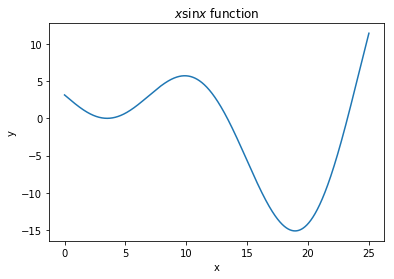

In [1]:
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt

def fun(point):
    return np.atleast_2d((point-3.5)*np.sin((point-3.5)/(np.pi)))

X_plot = np.atleast_2d(np.linspace(0, 25, 10000)).T
Y_plot = fun(X_plot)
#y_gpr , y_std = gpr.predict(X_plot , return_std=True)

lines = []
fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
lines.append(true_fun)
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [2]:
def cov_function(point_1,point_2,theta,sig):
    theta = np.asarray(theta)
    size = point_1.shape
    dist = (point_1-point_2)**2
    k_12 = (sig**2) * np.exp(- np.sum(dist / theta**2))
    return k_12

def cov_matrix(points,theta,sig):
    theta = np.asarray(theta)
    size = points.shape
    K = np.zeros((size[0],size[0]))
    for i,point in enumerate(points):
        K[:,i] = np.array([cov_function(point,point_1,theta,sig) for point_1 in points])
    return K

def cov_vect(point,points,theta,sig):
    theta = np.asarray(theta)
    size = points.shape
    K = np.array([cov_function(point,point_1,theta,sig) for point_1 in points])
    return K

## Exercice 1:

<div class="alert alert-warning">
    
**Question 1.1**<br>
Code the function that predicts the mean and the standard deviation of the Gaussian process.
</div>

In [3]:
# %load solutions/code1.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

def myGPpredict(x_new, x_data, y_data, K_inv, theta, sig):
    K_et = cov_vect(x_new,x_data,theta,sig)
    mu = K_et.dot(K_inv.dot(y_data))
    k_xx = cov_function(x_new,x_new,theta,sig)
    sigma = k_xx - K_et.dot(K_inv.dot(K_et.T))
    return mu[0],sigma


<div class="alert alert-warning">
    
**Question 1.2**<br>
Test several values of $\theta = [l, \sigma_f]$ with  $l$ defined as the length-scale  (of oscillations) and  $\sigma_f$ the amplitude. Look at the RMSE and R2 score that give an information on the accuracy of the model. RMSE must be close to 0 and R2 must be close to 1. For a reminder about these metrics, you can refer to https://en.wikipedia.org/wiki/Root-mean-square_deviation and https://en.wikipedia.org/wiki/Coefficient_of_determination.
</div>

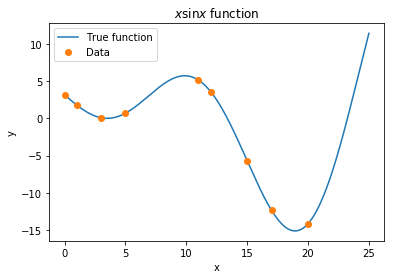

In [4]:
from sklearn.metrics import mean_squared_error, r2_score

x_test = np.atleast_2d(np.linspace(0,25,100)).T
y_test = fun(x_test)

x_data = np.atleast_2d([0,11,20,1,5,15,12,3,17]).T
y_data = fun(x_data)


X_plot = np.atleast_2d(np.linspace(0,25,1000)).T
Y_plot = fun(X_plot)

lines = []
fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
lines.append(true_fun)
lines.append(data)
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data'])
plt.show()

In [25]:
theta = [8.357]
sig = 1

In [26]:
# %load solutions/code2.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).
K = cov_matrix(x_data,theta,sig)
K_inv = np.linalg.inv(K)

y_pred = np.array([myGPpredict(x_t,x_data,y_data,K_inv,theta,sig) \
                   for x_t in x_test])



RMSE = 1.43807
R2 = 0.97100


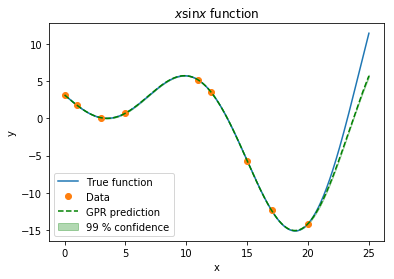

In [27]:
RMSE = mean_squared_error(y_test,y_pred[:,0])
R2 = r2_score(y_test,y_pred[:,0])
print('RMSE = %.5f' %(RMSE)) 
print('R2 = %.5f' %(R2))

Y_GP_plot = np.array([myGPpredict(x_t,x_data,y_data,K_inv,theta,sig) \
                   for x_t in X_plot])

fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot[:,0],linestyle='--',color='g')
un_gp = ax.fill_between(X_plot.T[0],Y_GP_plot[:,0]+3*Y_GP_plot[:,1],Y_GP_plot[:,0]-3*Y_GP_plot[:,1],alpha=0.3,color='g')
lines = [true_fun,data,gp,un_gp]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data','GPR prediction','99 % confidence'])
plt.show()

<div class="alert alert-warning">
    
**Question 1.3**<br>
Conclude: Is there a way to find a $\theta_{optimal} = \theta^*$?
</div>

Your answer : 

<div class="alert-danger"><a href="#answers1-3" data-toggle="collapse">
    
**Correction (click to unhide):**</a><br>
<div id="answers1-3" class="collapse">
TODO
</div>
</div>

# II. Hyperparameters Optimization

To train the model, the negative log marginal likelihood with respect to the hyper-parameters is minimized:

$$-\text{log}\, p(\mathbf{Y} \mid \mathbf{X}, \theta) = \frac{n}{2} \log(\frac{\mathbf{Y}^\top\mathbf{K}^{-1}\mathbf{Y}}{n}) + \frac{1}{2}\log\mid\mathbf{K}\mid + \,c,$$

where $c$ is a constant and the matrix $\mathbf{K}$ is a function of the hyper-parameters.

## Exercice 2:

<div class="alert alert-warning">
    
**Question 2.1**<br>
Plot a 1D graph of the Marginal Likelihood function for $l \in [10^{-3},1.25]$ at $\sigma_f$ fixed.
</div>

In [9]:
# %load solutions/code3.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

def likelihood(x_data,y_data,theta,sig):
    K = cov_matrix(x_data,theta,sig)
    args1 = y_data.T.dot(np.linalg.inv(K))
    args2 = np.log(args1.dot(y_data)/x_data.shape[0])
    args3 =  np.log(np.linalg.det(K))
    like = (x_data.shape[0])*args2 + args3
    return like[0,0]

Text(0.5,1,'Log Likelihood regarding theta')

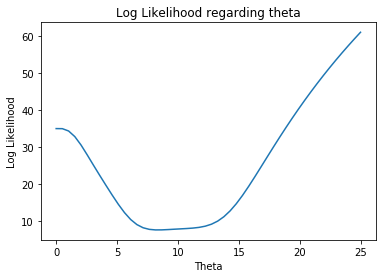

In [10]:
theta = np.linspace(1e-3,25)

like = np.array([likelihood(x_data,y_data,th,sig) for th in theta])

fig = plt.figure()
ax = fig.add_subplot(111)
line = ax.plot(theta,like)
ax.set_xlabel('Theta')
ax.set_ylabel('Log Likelihood')
ax.set_title('Log Likelihood regarding theta')

<div class="alert alert-warning">
    
**Question 2.2**<br>
Optimize the Marginal Likelihood function to find $l^*$.<br>Watch out: some optimizers are gradient-based and only converge to a local optimum (try different initializations).
</div>

In [21]:
from scipy.optimize import minimize 

like_obj = lambda theta : likelihood(x_data,y_data,theta,sig)


# Multistart to remove bad optimization results
theta_start = np.linspace(1e-6,25,5)

In [23]:
# %load solutions/code4.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

opt_all = np.array([minimize(like_obj, th, method='SLSQP', bounds=[(1e-6,25)]) for th in theta_start])


In [24]:
opt_success = opt_all[[opt_i['success'] for opt_i in opt_all]]
obj_success = np.array([opt_i['fun'] for opt_i in opt_success])
ind_min = np.argmin(obj_success)

opt = opt_success[ind_min]
theta_et = opt['x']

print('Optimization results', opt)
print('')
print('Best theta is %.5f' %(theta_et))

Optimization results      fun: 7.641224906721632
     jac: array([-0.00120544])
 message: 'Optimization terminated successfully.'
    nfev: 36
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([8.35057447])

Best theta is 8.35057


# III. Optimization

Now we would like to minimize a black box function subject to boundary constraints. This function is very expensive to evaluate and only provides a scalar output (meaning that you don't have access to gradients or higher order derivatives). We will use Gaussian Process to solve this optimization problem. 

Right now you can use directly smt which includes all these operations in a single procedure. Here, the data are the points $x_{data} = \left [0, 7, 25 \right ]$. 

# Exercice 3

The `fun` function from section I will play the role of our "expensive to evaluate function".

<div class="alert alert-warning">
    
**Question 3.1**<br>
Build the GP model with a square exponential kernel with scikit-learn toolbox knowing $(x_{data}, y_{data})$.
</div>

In [29]:
from smt.surrogate_models import KRG

x_data = np.atleast_2d([0,7,25]).T
y_data = fun(x_data)

In [31]:
help(KRG)

Help on class KRG in module smt.surrogate_models.krg:

class KRG(smt.surrogate_models.krg_based.KrgBased)
 |  KRG(**kwargs)
 |  
 |  Base class for all surrogate models.
 |  
 |  Attributes
 |  ----------
 |  options : OptionsDictionary
 |      Dictionary of options. Options values can be set on this attribute directly
 |      or they can be passed in as keyword arguments during instantiation.
 |  supports : dict
 |      Dictionary containing information about what this surrogate model supports.
 |  
 |  Examples
 |  --------
 |  >>> from smt.surrogate_models import RBF
 |  >>> sm = RBF(print_training=False)
 |  >>> sm.options['print_prediction'] = False
 |  
 |  Method resolution order:
 |      KRG
 |      smt.surrogate_models.krg_based.KrgBased
 |      smt.surrogate_models.surrogate_model.SurrogateModel
 |      builtins.object
 |  
 |  Data and other attributes defined here:
 |  
 |  __slotnames__ = []
 |  
 |  ----------------------------------------------------------------------
 |

In [30]:
# %load solutions/code5.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

gpr = KRG(theta0=[1e-2]*x_data.shape[1],print_prediction = False)
gpr.set_training_values(x_data,y_data)

gpr.train()


___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0222411


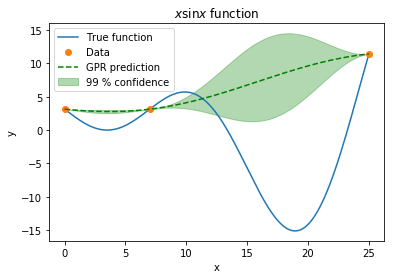

In [32]:
Y_GP_plot = gpr.predict_values(X_plot)
sig_GP_plot = gpr.predict_variances(X_plot)

fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot,linestyle='--',color='g')
sig_plus = Y_GP_plot+3*np.atleast_2d(sig_GP_plot)
sig_moins = Y_GP_plot-3*np.atleast_2d(sig_GP_plot)
un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
lines = [true_fun,data,gp,un_gp]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data','GPR prediction','99 % confidence'])
plt.show()

# Exercice 4

Suppose you are confronted to an optimization problem where each evaluation of the objective function is very expensive: let's say 10 hours per evaluation. You want to solve this problem under *computational budget contraints*.

Your challenge is: Minimize the $x \mapsto x \sin{(x)}$ function given a total computational budget of 10 points with the initial points $(x_{data},y_{data})$.

<div class="alert alert-warning">
    
**Question 4.1**<br>
Give at least 2 methods to optimize the true function thanks to Gaussian Processes. You don't have to code it explicitly, just give the main idea.
</div>

Your answer: 

<div class="alert-danger"><a href="#answers4-1" data-toggle="collapse">
    
**Correction (click to unhide):**</a><br>
<div id="answers4-1" class="collapse">
TODO
</div>
</div>

# Exercice 5 : Bayesian Optimization

Bayesian optimization is defined by Jonas Mockus in [3] as an optimization technique based upon the minimization of the expected deviation from the extremum of the studied function. 

[3]  J. Močkus.  On bayesian methods for seeking the extremum, pages 400–404. Springer Berlin Heidelberg, Berlin, Heidelberg, 1975.

The objective function is treated as a black-box function. A Bayesian strategy sees the objective as a random function and places a prior over it. The prior captures our beliefs about the behavior of the function. After gathering the function evaluations, which are treated as data, the prior is updated to form the posterior distribution over the objective function. The posterior distribution, in turn, is used to construct an acquisition function (often also referred to as infill sampling criterion) that determines what the next query point should be.

One of the earliest bodies of work on Bayesian optimisation is [4,5]. Kushner used [Wiener processes](https://en.wikipedia.org/wiki/Stochastic_process#Wiener_process) (Brownian motion processes) for one-dimensional problems. Kushner’s decision model was based on maximizing the probability of improvement, and included a parameter that controlled the trade-off between ‘more global’ and ‘more local’ optimization, in the same spirit as the Exploration/Exploitation trade-off.

[4] Harold J Kushner. A Versatile Stochastic Model of a Function of Unknown and Time-Varying Form. vol. 5, pages 150–167, 08 1962.<br>
[5] Harold J Kushner. A New Method of Locating the Maximum Point of an Arbitrary Multipeak Curve in the Presence of Noise. vol. 86, 01 1964.

Meanwhile, in the former Soviet Union, Mockus and colleagues developed a multidimensional Bayesian optimization method using linear combinations of Wiener fields, some of which was published in English in [3]. This paper also describes an acquisition function that is based on myopic expected improvement of the posterior, which has been widely adopted in Bayesian optimization as the Expected Improvement function.

In 1998, Jones used Gaussian processes together with the expected improvement function to successfully perform derivative-free optimization and experimental design through an algorithm called  Efficient  Global  Optimization, or EGO [6].

[6] Donald R. Jones, Matthias Schonlau and William J. Welch. Efficient Global Optimization of Expensive Black-Box Functions. J. of Global Optimization, vol. 13, no. 4, pages 455–492, 1998.

## Efficient Global Optimization

In what follows, we describe the Efficient Global Optimization (EGO) algorithm, as published in |6].

Let $F$ be an expensive black-box function to be minimized. We sample $F$ at the different locations  $X = \{x_1, x_2,\ldots,x_n\}$ yielding the responses $Y = \{y_1, y_2,\ldots,y_n\}$. We build a Kriging model (also called Gaussian process) with a mean function $\mu$ and a variance function $\sigma^{2}$.

The next step is to compute the criterion EI. To do this, let us write:

$$f_{min} = \min \{y_1, y_2,\ldots,y_n\}.$$

The Expected Improvement funtion (EI) can be expressed as:

$$E[I(x)] = E[\max(f_{min}-Y, 0)],$$

where $Y$ is the random variable following the distribution $\mathcal{N}(\mu(x), \sigma^{2}(x))$.
By rewriting the right-hand side of EI's expression as an integral, and applying some tedious integration by parts, one can express the expected improvement in closed form:

\begin{equation}
E[I(x)] = (f_{min} - \mu(x))\Phi\left(\frac{f_{min} - \mu(x)}{\sigma(x)}\right) + \sigma(x) \phi\left(\frac{f_{min} - \mu(x)}{\sigma(x)}\right)
\label{eq:EI_simp}
\end{equation}

where $\Phi(\cdot)$ and $\phi(\cdot)$ are respectively the cumulative and probability density functions of $\mathcal{N}(0,1)$.

Next, we determine our next sampling point as :
\begin{align}
x_{n+1} = \arg \max_{x} \left(E[I(x)]\right)
\end{align}

We then test the response $y_{n+1}$ of our black-box function $F$ at $x_{n+1}$, rebuild the model taking into account the new information gained, and research the point of maximum expected improvement again.

We summarize here the EGO algorithm:

EGO(F, $n_{iter}$ \# Find the best minimum of $\operatorname{F}$ in $n_{iter}$ iterations  
For ($i=0:n_{iter}$)  

* $mod = {model}(X, Y)$  \# surrogate model based on sample vectors $X$ and $Y$  
* $f_{min} = \min Y$  
* $x_{i+1} = \arg \max {EI}(mod, f_{min})$ \# choose $x$ that maximizes EI  
* $y_{i+1} = {F}(x_{i+1})$ \# Probe the function at most promising point $x_{i+1}$  
* $X = [X,x_{i+1}]$  
* $Y = [Y,y_{i+1}]$   
* $i = i+1$  

$f_{min} = \min Y$  
Return : $f_{min}$ \# This is the best known solution after $n_{iter}$ iterations

<div class="alert alert-warning">
    
**Question 5.1**<br>
Implement the Expected Improvement function.
</div>

In [33]:
from scipy.stats import norm

In [34]:
# %load solutions/code6.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

def EI(GP,points,f_min):
    pred_mu = GP.predict_values(points)
    pred_sig = GP.predict_variances(points)
    args0 = (f_min - pred_mu)/np.atleast_2d(pred_sig)
    args1 = (f_min - pred_mu)*norm.cdf(args0)
    args2 = np.atleast_2d(pred_sig)*norm.pdf(args0)
    ei = args1 + args2
    return ei

(1000, 1)


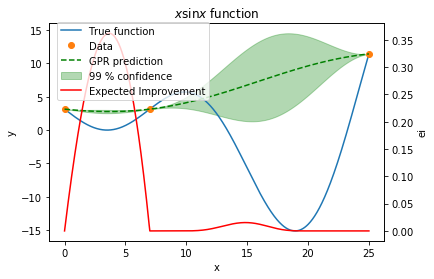

In [35]:
Y_GP_plot = gpr.predict_values(X_plot)
sig_GP_Plot = gpr.predict_variances(X_plot)
Y_EI_plot = EI(gpr,X_plot,np.min(y_data))
print(Y_EI_plot.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot,linestyle='--',color='g')
sig_plus = Y_GP_plot+3*np.atleast_2d(sig_GP_Plot)
sig_moins = Y_GP_plot-3*np.atleast_2d(sig_GP_Plot)
un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
ax1 = ax.twinx()
ei, = ax1.plot(X_plot,Y_EI_plot,color='red')
lines = [true_fun,data,gp,un_gp,ei]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax1.set_ylabel('ei')
fig.legend(lines,['True function','Data','GPR prediction','99 % confidence','Expected Improvement'],loc=[0.13,0.64])
plt.show()

<div class="alert alert-warning">
    
**Question 5.2**<br>
Complete the code of the EGO method and compare it to other infill criteria.
</div>

In [116]:
def SBO(GP,point):
    res = GP.predict(point)
    return res

def UCB(GP,point):
    pred = GP.predict(point,return_std=True)
    return pred[0]-3.*pred[1]

plt.ion()

x_data = np.atleast_2d([0,7,25]).T
y_data = fun(x_data)

n_iter = 17

gpr = KRG(theta0=[1e-2]*x_data.shape[1],print_prediction = False,print_global=False)
gpr.set_training_values(x_data,y_data)

gpr.train()

In [117]:
# %load solutions/code7.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

for k in range(n_iter):
    x_start = np.atleast_2d(np.random.rand(15)*25).T
    f_min_k = np.min(y_data)
    gpr.set_training_values(x_data, y_data)
    gpr.train()
    obj_k = lambda x: -EI(gpr,np.atleast_2d(x),f_min_k)
    ## UNCOMMENT ONE OF THE INFILL CRITERIA
    obj_k = lambda x: -EI(gpr,np.atleast_2d(x),f_min_k)
    # obj_k = lambda x: SBO(gpr,np.atleast_2d(x))
    # obj_k = lambda x: UCB(gpr,np.atleast_2d(x))
    
    opt_all = np.array([minimize(obj_k, x_st, method='SLSQP', bounds=[(0,25)]) for x_st in x_start])
    opt_success = opt_all[[opt_i['success'] for opt_i in opt_all]]
    obj_success = np.array([opt_i['fun'] for opt_i in opt_success])
    ind_min = np.argmin(obj_success)
    opt = opt_success[ind_min]
    x_et_k = opt['x']
    
    y_et_k = fun(x_et_k)
    
    y_data = np.atleast_2d(np.append(y_data,y_et_k)).T
    x_data = np.atleast_2d(np.append(x_data,x_et_k)).T
    
ind_best = np.argmin(y_data)
x_opt = x_data[ind_best]
y_opt = y_data[ind_best]

Results : X = [18.93346806], Y = [-15.12510071]


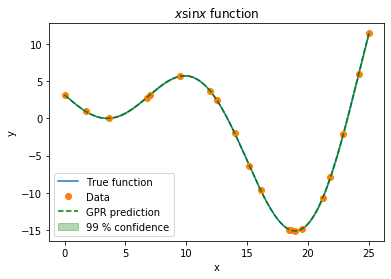

In [118]:
print('Results : X = %s, Y = %s' %(x_opt,y_opt))

Y_GP_plot = gpr.predict_values(X_plot)
sig_GP_Plot = gpr.predict_variances(X_plot)

fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot,linestyle='--',color='g')
sig_plus = Y_GP_plot+3*np.atleast_2d(sig_GP_Plot)
sig_moins = Y_GP_plot-3*np.atleast_2d(sig_GP_Plot)
un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
lines = [true_fun,data,gp,un_gp]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data','GPR prediction','99 % confidence'])
plt.show()

# Recap: Play with a web app from Rasmussen

[https://drafts.distill.pub/gp](https://drafts.distill.pub/gp)